In [0]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
%cd /content/gdrive/My\ Drive/630final

/content/gdrive/My Drive/630final


In [0]:
import pandas as pd

train_df = pd.read_csv('./data/train.csv')
val_df = pd.read_csv('./data/dev.csv')
test_df = pd.read_csv('./data/test.csv')

In [0]:
train_df['text'] = train_df.apply(lambda x:x['original'].replace(x['original'][x['original'].find('<'):x['original'].find('>')+1],x['edit']) ,axis=1)
val_df['text'] = val_df.apply(lambda x:x['original'].replace(x['original'][x['original'].find('<'):x['original'].find('>')+1],x['edit']) ,axis=1)
test_df['text'] = test_df.apply(lambda x:x['original'].replace(x['original'][x['original'].find('<'):x['original'].find('>')+1],x['edit']) ,axis=1)

In [0]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

train_tagged = train_df.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r['meanGrade']]), axis=1)
test_tagged= val_df.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r['meanGrade']]), axis=1)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [0]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 9652/9652 [00:00<00:00, 1148009.93it/s]


In [0]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 9652/9652 [00:00<00:00, 2776069.55it/s]


CPU times: user 22.2 s, sys: 3.3 s, total: 25.5 s
Wall time: 16.2 s


In [0]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [0]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

for i in [1,10,100,1000]:
  clf = SVR(C=i)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  yy_test = np.array(val_df['meanGrade'])
  print(i,mean_squared_error(yy_test, y_pred, squared=False))

1 0.580406325502122
10 0.5849076945927966
100 0.584575247839623
1000 0.5847227160678179


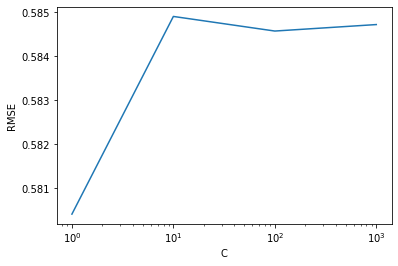

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns

x =  [1,10,100,1000]
y = [0.580406325502122,0.5849076945927966,0.584575247839623,0.5847227160678179]
df1 = pd.DataFrame(data=y, index=x)
df2 = pd.DataFrame(data = {'C': x, 'RMSE': y})

ax = sns.lineplot(x="C", y="RMSE", data=df2)    

ax.set_xscale('log')


In [0]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import validation_curve

for i in [1,0.1,0.01,0.001]:
  clf = KernelRidge(alpha=i)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  yy_test = np.array(val_df['meanGrade'])
  print(i,mean_squared_error(yy_test, y_pred, squared=False))


1 0.5803974020452898


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.91278e-08): result may not be accurate.
  overwrite_a=False)


0.1 0.5801524415735417


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.04177e-10): result may not be accurate.
  overwrite_a=False)


0.01 0.600815589345274


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


In [0]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

for i in range(1,10):
  clf = RandomForestRegressor(n_estimators=10,max_depth=i)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  yy_test = np.array(val_df['meanGrade'])
  print(i,mean_squared_error(yy_test, y_pred, squared=False))

for i in range(10,90,10):
  clf = RandomForestRegressor(n_estimators=i,max_depth=2)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  yy_test = np.array(val_df['meanGrade'])
  print(i,mean_squared_error(yy_test, y_pred, squared=False))

1 0.5782178067521516
2 0.5799051854533895
3 0.581230435463154
4 0.5827424659614634
5 0.5820960120596202
6 0.5829879629659083
7 0.5843096615009998
8 0.588643382232422
9 0.5870372398486845
10 0.5801402280554506
20 0.5800543357601361
30 0.5795091402120779


KeyboardInterrupt: ignored